In [1]:
import numpy as np
import warnings

from scipy.stats import expon, norm, uniform

from envs.vases_grid import VasesGrid, VasesEnvState, print_state, str_to_state, state_to_str
from envs.utils import unique_perm, zeros_with_ones, printoptions
from envs.vases_spec import VasesEnvState2x3V2D3, VasesEnvSpec2x3V2D3, VasesEnvState2x3Broken, VasesEnvSpec2x3Broken

from value_iter_and_policy import vi_boltzmann_deterministic, vi_rational_deterministic


def forward_rl(env, r, gamma=.97, steps_printed=15, current_s=None):
    '''Given an env and R, runs soft VI for h steps and rolls out the resulting policy'''
    V, Q, policy = vi_rational_deterministic(env, r=env.f_matrix @ r, gamma=gamma) 
    
    if current_s is None: 
        env.reset()
    else:
        env.s = str_to_state(env.num_state[np.where(current_s)[0][0]])
    print_state(env.s); print()
    for i in range(steps_printed):
        a = np.random.choice(5,p=policy[env.state_num[state_to_str(env.s)],:])
        env.state_step(a)
        print_state(env.s)
        print()


class neg_exp_distr(object):
    '''
    a wrapper to not get confused with the negative exp distribuion,
    as scipy doesn't have a good way to do *negative* exp
    '''
    def __init__(self, mode, scale=1):
        self.mode = mode
        self.scale = scale
        self.distribution = expon(loc=-mode, scale=scale)
        
    def rvs(self):
        '''sample'''
        return -self.distribution.rvs()
    
    def pdf(self, x):
        return self.distribution.pdf(-x)
    
    def logpdf(self, x):
        return self.distribution.logpdf(-x)
    
        
def birl_1s_log_likel(s_current, V, temp=1):
    return (V[np.where(s_current)])/temp
    

def policy_walk(env, r_spec, r_prior, s_current, step_size, gamma, n_samples):
    '''
    Algo inspired by one in Appendix A from https://arxiv.org/pdf/1807.05037.pdf,
    should be equivalent to the original BIRL (but for one state)
    '''
    i=0
    a_list = []
    
    log_p = np.log(.5)
    samples = []
    
    r = r_prior.rvs()
    V, Q, pi = vi_rational_deterministic(env, gamma=gamma, r=env.f_matrix @ r)
    
    while True:
        r_prime = np.random.normal(r, step_size)                
        V_prime, Q_prime, pi_prime = vi_rational_deterministic(env, gamma=gamma,
                                                               r=env.f_matrix @ r_prime,
                                                               init_V = V)
        
        log_p_1 = birl_1s_log_likel(s_current, V_prime) + np.sum(r_prior.logpdf(r_prime))
        
        # acceptance prob
        a = np.exp(log_p_1-log_p)  
        # accept or reject the new sample
        if np.random.uniform()<np.amin(np.array([1, a])):
            samples.append(r_prime)
            r = np.copy(r_prime)
            V = np.copy(V_prime)
            log_p = np.copy(log_p_1)
        else:
            # reject the generated sample; the new sample equals previous sample 
            samples.append(r)
            
        # adjust step size based on acceptance prob
        # this is a bit wacky, but does make the choice of step_size less important
        # (turned off for now)
        if False:
            a_list.append(a[0][0])
            a_running_mean = np.convolve(np.array(a_list), np.ones((25,))/25, mode='valid')
            if a_running_mean[-1]<10e-2:
                step_size = .99*step_size
            if a_running_mean[-1]>1:
                step_size = 1.01*step_size
            
            
        if len(samples)%500==0:
            if i!=len(samples):
                i = len(samples)
                print('samples generated: ', len(samples))
                #print(a_running_mean[-1])
                # monitoring acceptance prob; we don't want this to be very high or very low
                print(a[0][0])
        
        if len(samples)==n_samples:
            return samples


In [2]:
env2x3v2d3 = VasesGrid(VasesEnvSpec2x3V2D3(), VasesEnvState2x3V2D3())
r_spec = np.array([0, 0, 1, 0, 0, 0])
s_current = np.zeros(env2x3v2d3.nS)
s_current[1582] = 1
print_state(str_to_state(env2x3v2d3.num_state[1582]))

│██│  │ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │


In [3]:
warnings.filterwarnings('error')
gamma=.99

# Negative exponential prior with mode at r_spec
r_prior = neg_exp_distr(mode=r_spec, scale=.2); step_size=.0003

# Gaussian prior with mean at r_spec
# r_prior = norm(loc=r_spec, scale=.05); step_size=.01

# Uniform prior centered at r_pec. Subtracting half scale such that center of the 
# distribution is at loc, as oppposed to the lowest end
# scale=2; loc=r_spec-.5*scale; r_prior = uniform(loc=loc, scale=scale); step_size=.01

r_samples = policy_walk(env2x3v2d3, r_spec, r_prior, s_current, 
                        gamma=gamma, step_size=step_size, n_samples=3000)

samples generated:  500
1.0286901203266405
samples generated:  1000
1.0580738204042717
samples generated:  1500
0.9897642252415313
samples generated:  2000
0.9626450966138974
samples generated:  2500
1.0255240144962738
samples generated:  3000
0.9919970914972589


[-0.635  -0.6957  0.9075 -0.2249 -0.0506 -0.1781]


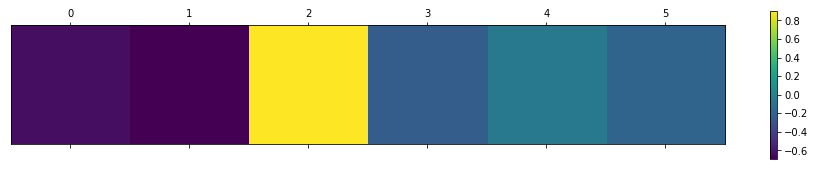

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

'''
Order of features:
- Number of broken vases
- Number of vases on tables
- Number of tablecloths on tables
- Number of tablecloths on floors
- Number of vases on desks
- Number of tablecloths on desks
'''
with printoptions(precision=4, suppress=True):
    res = np.mean(r_samples[1000::], axis=0)
    print(res)
    plt.matshow(res.reshape(1,-1))
    plt.yticks([], [])
    plt.colorbar()

In [5]:
forward_rl(env2x3v2d3, np.mean(r_samples[1000::], axis=0), gamma=gamma, steps_printed=100)

│██│  │ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │

│█ │  │ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │

│█ │  │ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │→ │  │

│█ │  │ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │↑ │  │

│█ │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │↑ │  │

│█ │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│← │  │  │

│█ │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │

│  │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │

│  │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │→ │  │

│  │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │→ │  │

│  │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │  │→ │

│  │ █│ █│
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │  │↑ │

│  │ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │  │↑ │

│  │ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │← │  │

│  │ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│← │  │  │

│  │ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│↑ │  │  │

│ █│ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│↑ │  │  │

│ █│ █│  │
│█ │█ │█ │
│──│──│──│
│  │  │█ │
│  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │↑ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │← │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│← │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↓ │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↓ │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│↑ │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│← │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│← │  │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │→ │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │↓ │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │→ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │→ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │↓ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │↓ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │← │  │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │→ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │  │→ │

│ █│  │█ │
│█ │█ │█ │
│──│──│──│
│  │  │  │
│  │